# Random Variables

In the following sections we illustrate some basic usage of random variables and linear operators in ProbNum. We begin by creating random variables, the primary in- and outputs of probabilistic numerical methods.

In [11]:
# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [9.5, 6]
plt.rcParams['font.size'] = 18 
plt.rcParams['text.usetex'] = True

## Univariate Random Variables

Instantiate and manipulate random variables and linear operators.

In [34]:
import numpy as np
from probnum.probability import RandomVariable, Normal

# Random seed
np.random.seed(42)

# Gaussian random variable
X = RandomVariable(distribution=Normal(mean=0, cov=1))

# Arithmetic operations between scalars and random variables
Y = 2 * X - 3
print(Y)

<() RandomVariable with dtype=<class 'float'>>


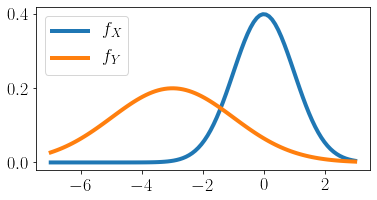

In [35]:
# Plot of probability density functions of X and Y
xx = np.linspace(-7, 3, num=100)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
axes.plot(xx, X.distribution.pdf(xx), label="$f_X$", linewidth=4)
axes.plot(xx, Y.distribution.pdf(xx), label="$f_Y$", linewidth=4)
axes.legend()
plt.show()

## Arithmetic Operations

Perform basic arithmetic operations (addition, multiplication, ...) between scalars or vectors and random variables. You can also apply linear transformations and make use of broadcasting.

### Vectors and Matrices

In [29]:
# Affine transformation of a random variable
A = np.array([[1, 2], 
              [3, 2]])
X = RandomVariable(distribution=Normal(mean=np.array([1, 2]), cov=np.array([[5, 0], 
                                                                            [0, 2]])))
Y = A @ (- X) + np.array([1, 2])
print(Y)

<(2,) RandomVariable with dtype=<class 'float'>>


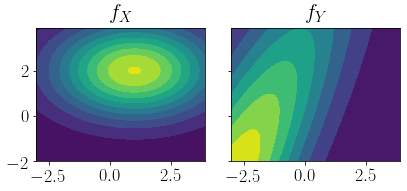

In [30]:
# Contour plot of the probability density functions of X and Y
delta = 0.1
uu = np.arange(-3, 4, delta)
vv = np.arange(-2, 4, delta)
U, V = np.meshgrid(uu, vv)

rvdict = {"$f_X$" : X, "$f_Y$" : Y}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].contourf(U, V, rv.distribution.pdf(np.dstack((U, V))), levels=10)
    axes[i].title.set_text(title)
plt.tight_layout()

### Linear Operators

In [27]:
from probnum.linalg import aslinop

# Linear operators applied to random variables
A = aslinop(np.array([[1, 2], 
                      [2, 4],
                      [-1, 0]]))
Y = A @ X

# Broadcasting
Y = Y + 1
print(Y.distribution.parameters)

{'mean': array([ 6, 11,  0]), 'cov': array([[ 13,  26,  -5],
       [ 26,  52, -10],
       [ -5, -10,   5]])}


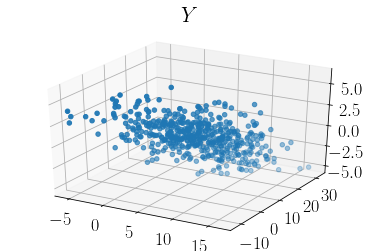

In [28]:
# Scatter plot
from mpl_toolkits.mplot3d import Axes3D

s = Y.sample(500)

fig = plt.figure(figsize=(5, 3))
ax = Axes3D(fig)
ax.scatter(s[:, 0], s[:, 1], s[:, 2])
ax.title.set_text("$Y$")

## Matrix-variate Random Variables

In [ ]:
# Matrix-variate normal distribution

## Linear Operators as Random Variables

In [4]:
# Linear operators _as_ random variables